In [201]:
# Imported libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import squarify as sq
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

In [202]:
# Read RFM_Final dataset
df = pd.read_csv('./datasets/1_SEGMENTATION/RFM_Final.csv')
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,POINTS_SPENT,loyalty_score,LONGEVITY,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,AA00312188,25,102,1040,8760,1,4709,2,3,4,234,9,Platinum
1,AA00312390,2,58,687,2240,1,3759,4,2,3,423,9,Platinum
2,AA00325975,2,205,1386,80675,1,5233,4,4,4,444,12,Platinum
3,AA00336843,15,69,498,24255,1,1793,2,3,2,232,7,Silver
4,AA00339761,24,59,574,4030,1,5481,2,2,3,223,7,Silver


In [203]:
# Create a copy dataset with the same index as the original dataset to avoid any issues when merging the datasets
df_copy = df.copy()

In [204]:
df_copy.columns

Index(['CUSTOMER_ID', 'Recency', 'Frequency', 'Monetary', 'POINTS_SPENT',
       'loyalty_score', 'LONGEVITY', 'R', 'F', 'M', 'RFM_Segment', 'RFM_Score',
       'General_Segment'],
      dtype='object')

In [205]:
# Drop the columns that are not needed for the clustering analysis
df_copy = df_copy.drop(['CUSTOMER_ID', 'R', 'F', 'M', 'RFM_Segment',
       'General_Segment', 'RFM_Score', 'POINTS_SPENT',
       'loyalty_score', 'LONGEVITY'], axis=1)

# Check the columns that are left in the dataset
df_copy.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

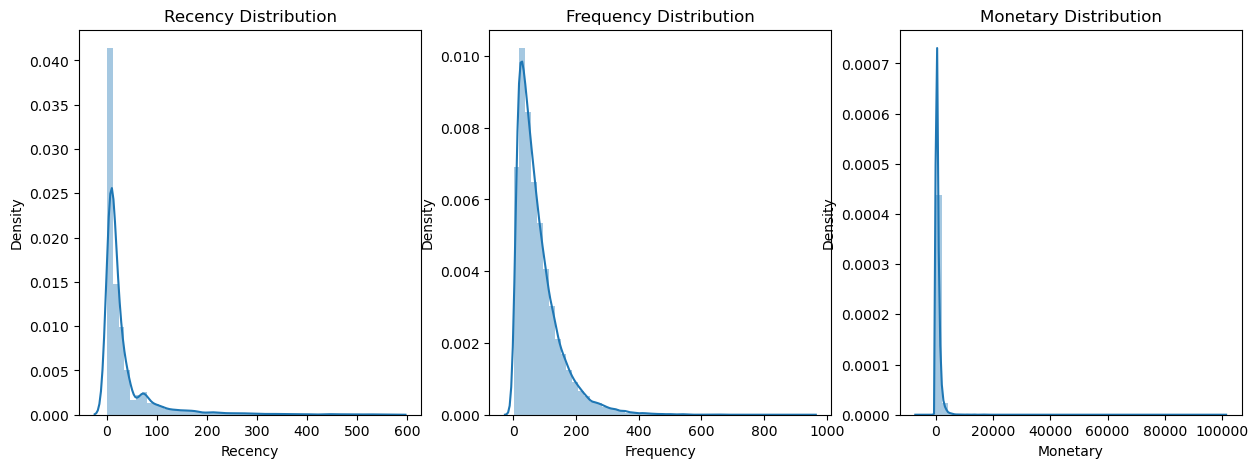

In [206]:
# Plot the distribution of the data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.distplot(df_copy['Recency'])
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.distplot(df_copy['Frequency'])
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.distplot(df_copy['Monetary'])
plt.title('Monetary Distribution')

plt.show()

- The data from `recency`, `frequency` and `monetary` are all skewed heavily to the left.
- The skeweness must be eliminated before proceeding

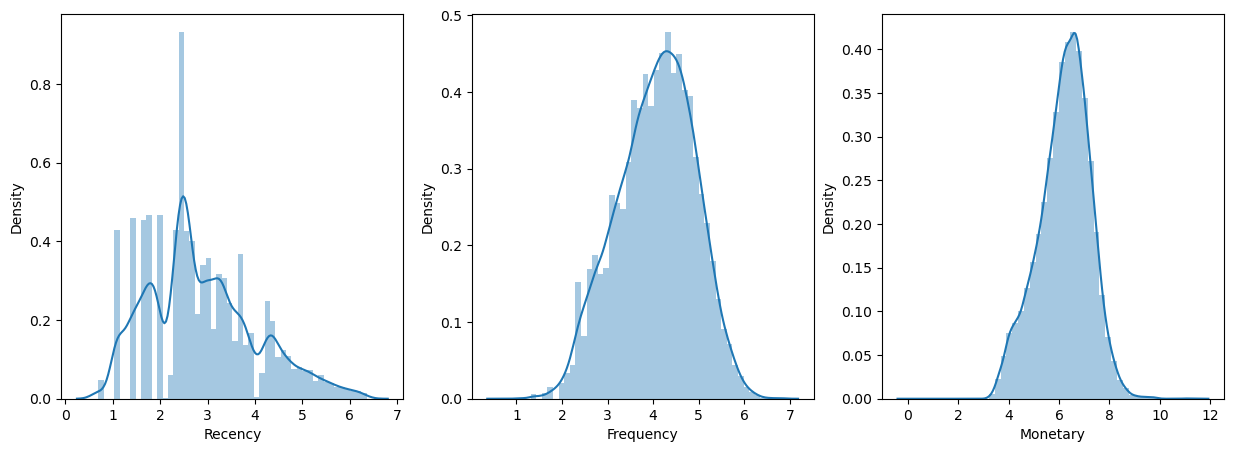

In [207]:
# Removal of skewness
recency_log = np.log1p(df_copy['Recency'])
frequency_log = np.log1p(df_copy['Frequency'])
monetary_log = np.log1p(df_copy['Monetary'])

plt.figure(figsize=(15,5))

# Plotting the distribution of Recency
plt.subplot(1,3,1)
sns.distplot(recency_log)

# Plotting the distribution of Frequency
plt.subplot(1,3,2)
sns.distplot(frequency_log)

# Plotting the distribution of Monetary
plt.subplot(1,3,3)
sns.distplot(monetary_log)

plt.show()

In [208]:
scaler_rfm = StandardScaler()
scaler_rfm.fit(df_copy)

# Standardizing the data
rfm_standardized = scaler_rfm.transform(df_copy)

print('mean:', rfm_standardized.mean(axis=0).round(2))
print('std:', rfm_standardized.std(axis=0).round(2))

mean: [ 0.  0. -0.]
std: [1. 1. 1.]


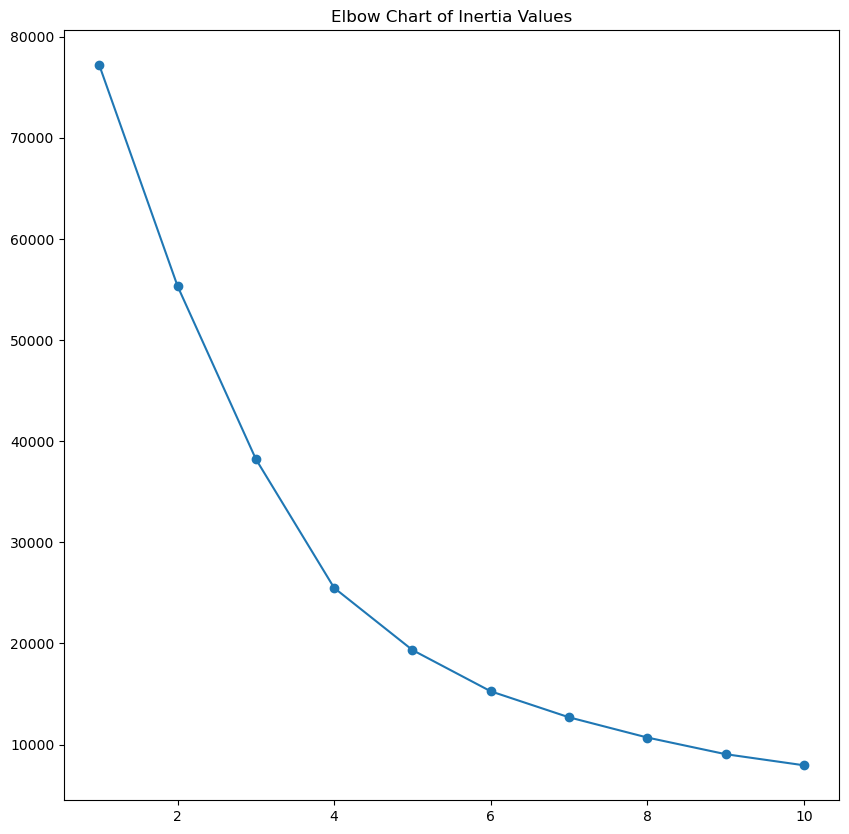

In [209]:
# KMeans Clustering
inertia = []

# Create a range of K values
k_values = range(1, 11)

# Loop through the K values
for k in k_values:
    # Create a KMeans object
    kmeans = KMeans(n_clusters=k, random_state=1)
    # Fit the KMeans object to the PCA data
    kmeans.fit(rfm_standardized)
    # Append the inertia value to the list
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(10, 10))
plt.title('Elbow Chart of Inertia Values')
plt.plot(k_values, inertia, marker='o')

In [210]:
# Selection of the optimal number of clusters
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(rfm_standardized)
df['Cluster'] = kmeans.labels_

# Calculate the average RFM values and size for each cluster
cluster_avg = df.groupby(['Cluster']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(0)

# Print the average values
print(cluster_avg)

        Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          31.0      43.0    394.0  15270
1          10.0     280.0   3418.0   1323
2          12.0     128.0   1243.0   7681
3         253.0      23.0    212.0   1448
4          39.0     103.0  74381.0      5


In [213]:
# # Fit the hierarchical clustering to the dataset
# linked = linkage(rfm_standardized, 'ward')

# # Create a dendrogram
# plt.figure(figsize=(10, 7))
# dendrogram(linked, orientation='top', distance_sort=True, show_leaf_counts=True)

# # Visualize the dendrogram
# plt.show()

In [214]:
# Create an Agglomerative Clustering object
agg_clustering = AgglomerativeClustering(n_clusters=5)

# Fit the object to the data
agg_clustering.fit(rfm_standardized)

# Assign the clusters to the data
df['Cluster_Agglomerative'] = agg_clustering.labels_

# Calculate the average RFM values and size for each cluster
alg_cluster_avg = df.groupby(['Cluster_Agglomerative']).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(0)

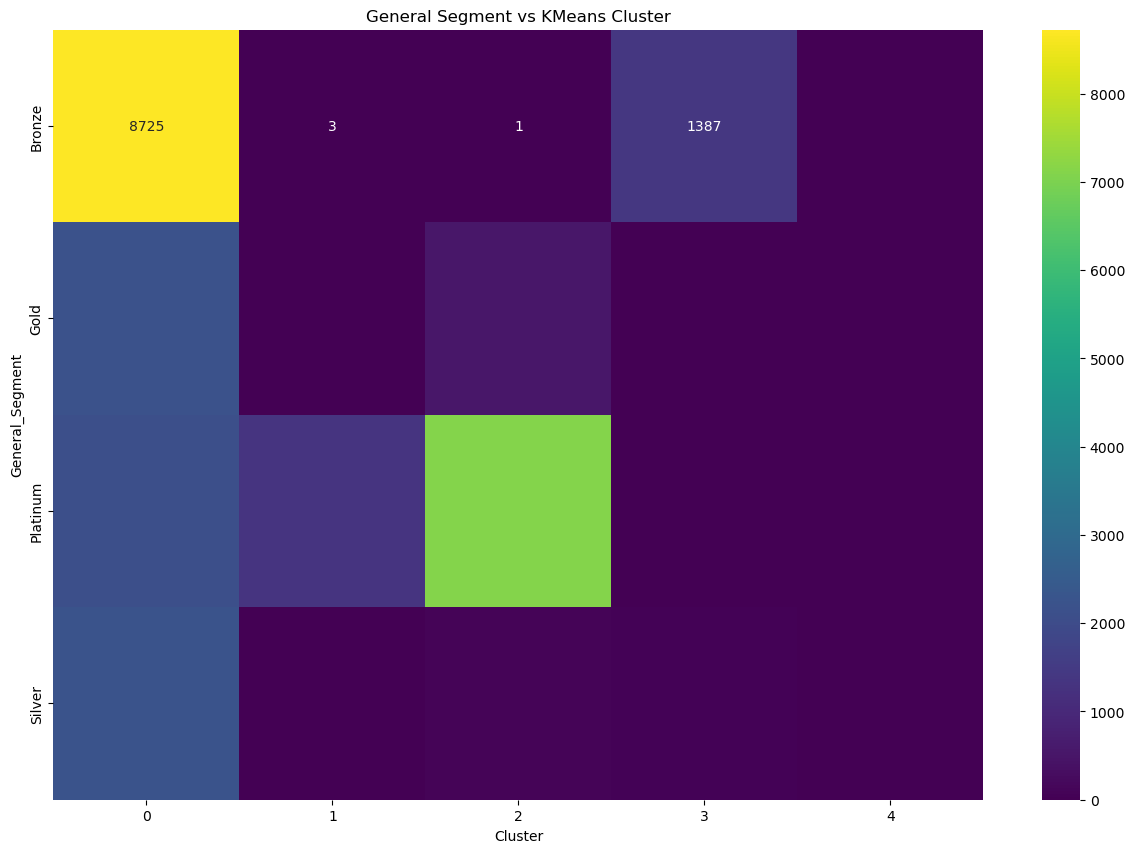

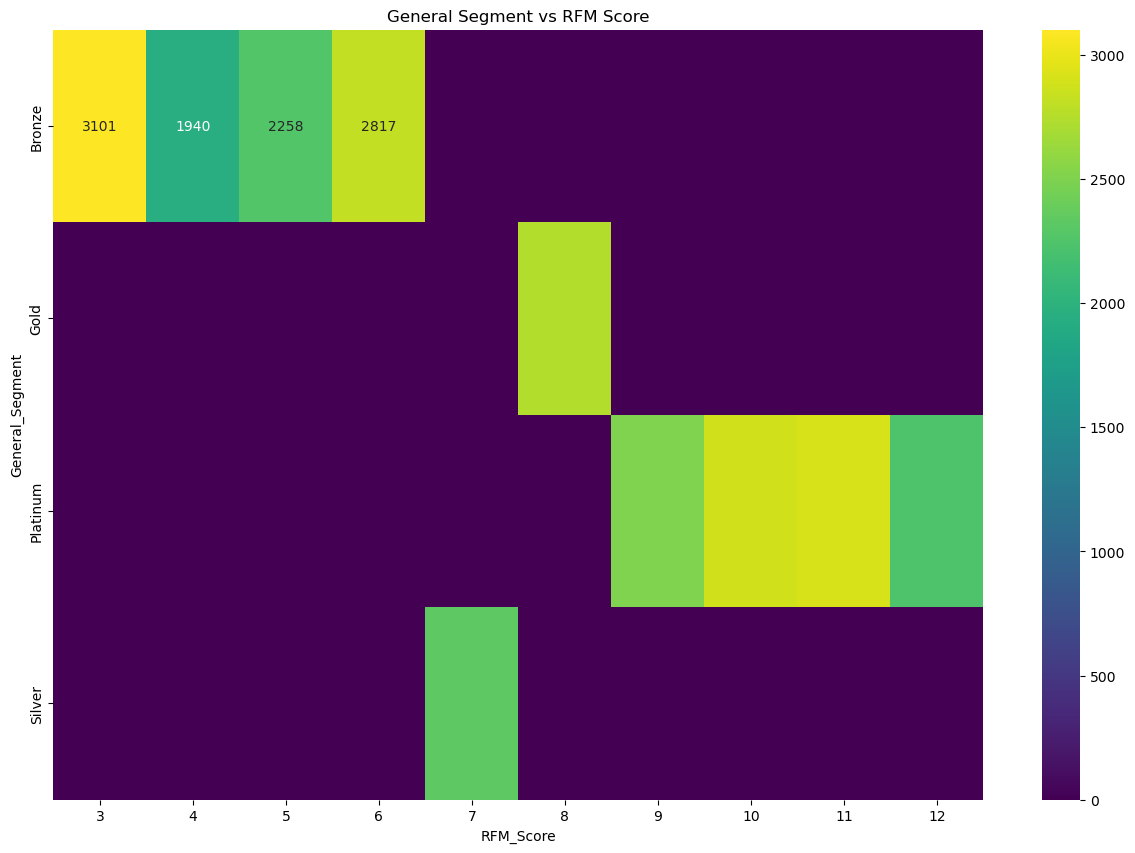

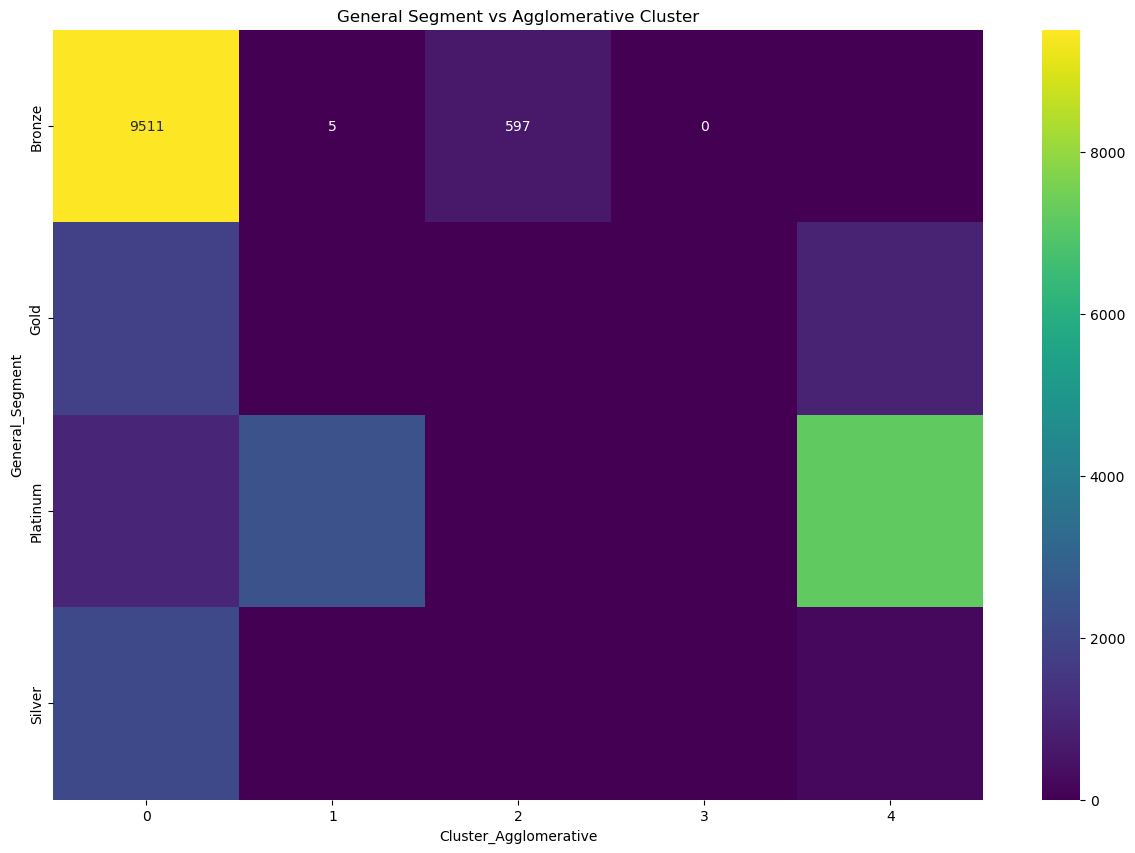

In [217]:
# Plotting a heatmap of the general segment and the clusters
plt.figure(figsize=(15, 10))
sns.heatmap(pd.crosstab(df['General_Segment'], df['Cluster']), annot=True, fmt='d', cmap='viridis')
plt.title('General Segment vs KMeans Cluster')
plt.show()

# Plotting a heatmap of the general segment and the RFM_Score
plt.figure(figsize=(15, 10))
sns.heatmap(pd.crosstab(df['General_Segment'], df['RFM_Score']), annot=True, fmt='d', cmap='viridis')
plt.title('General Segment vs RFM Score')
plt.show()

# Plotting a heatmap of the general segment and the Agglomerative Clustering
plt.figure(figsize=(15, 10))
sns.heatmap(pd.crosstab(df['General_Segment'], df['Cluster_Agglomerative']), annot=True, fmt='d', cmap='viridis')
plt.title('General Segment vs Agglomerative Cluster')
plt.show()

In [218]:
# Print the average values from KMeans and Agglomerative Clustering
print(cluster_avg)
print(alg_cluster_avg)

        Recency Frequency Monetary       
           mean      mean     mean  count
Cluster                                  
0          31.0      43.0    394.0  15270
1          10.0     280.0   3418.0   1323
2          12.0     128.0   1243.0   7681
3         253.0      23.0    212.0   1448
4          39.0     103.0  74381.0      5
                      Recency Frequency Monetary       
                         mean      mean     mean  count
Cluster_Agglomerative                                  
0                        42.0      39.0    346.0  14404
1                        10.0     236.0   2802.0   2392
2                       349.0      20.0    175.0    624
3                        39.0     103.0  74381.0      5
4                        12.0     110.0   1035.0   8302


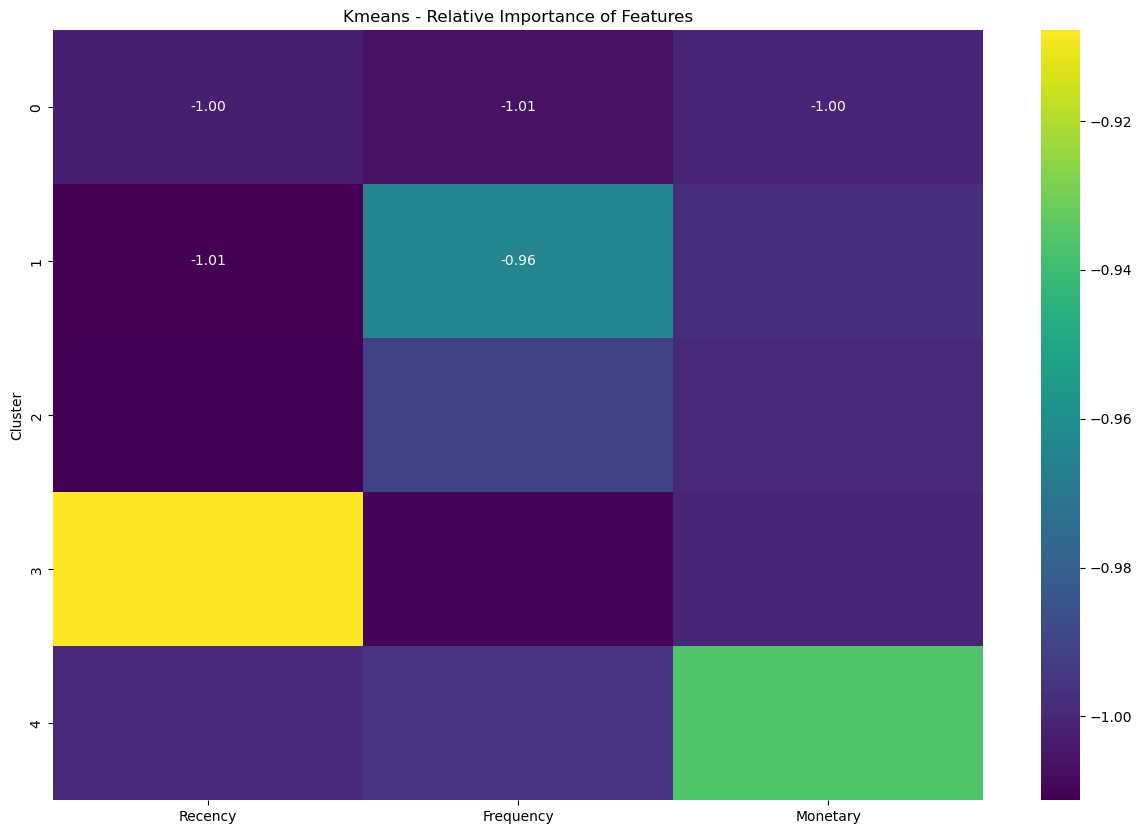

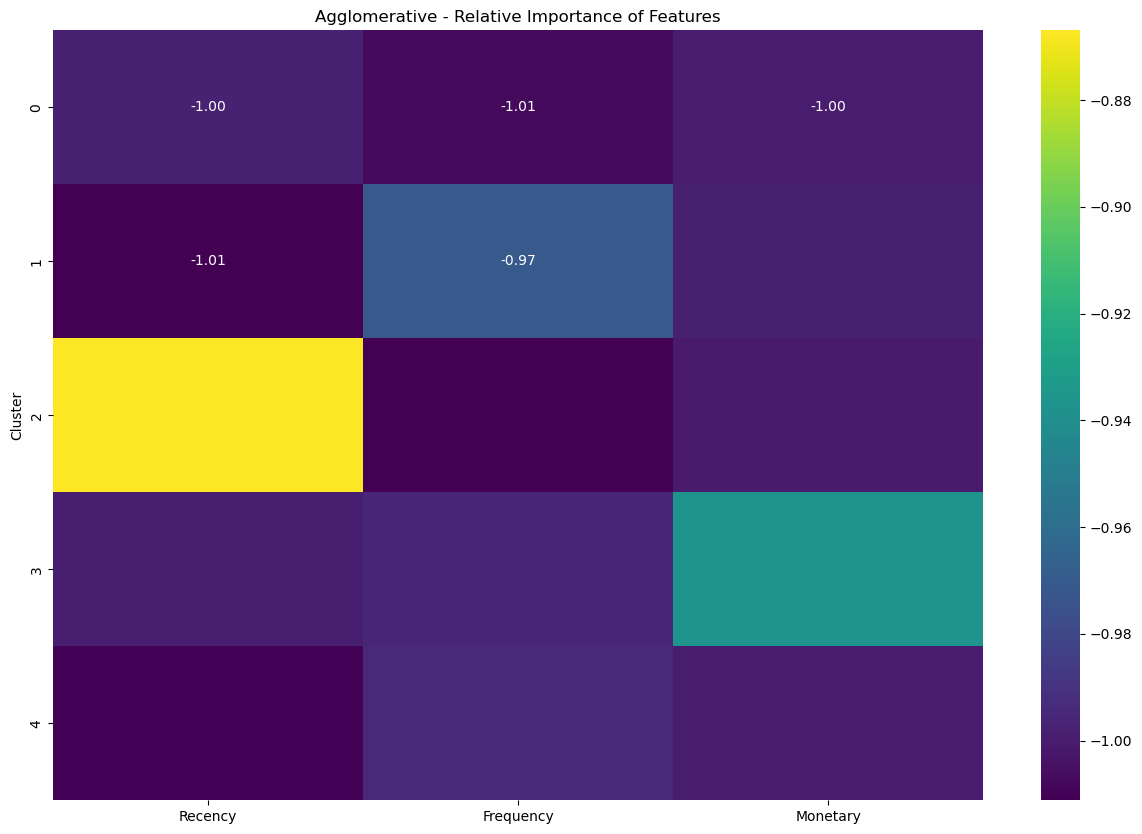

In [220]:
# Relative Importance Score:
# The relative importance score is a way to identify the most important features in a clustering analysis.
# The further the score is to 0, the more important the feature is to the cluster.
df_norm_kmeans = pd.DataFrame(rfm_standardized, columns=df_copy.columns, index=df_copy.index)
df_norm_kmeans['Cluster'] = df['Cluster']

kmeans_avg = df_norm_kmeans.groupby(['Cluster']).mean()
kmeans_pop_avg = df_copy.mean()
relative_importance = kmeans_avg / kmeans_pop_avg - 1

plt.figure(figsize=(15, 10))
sns.heatmap(relative_importance, annot=True, fmt='.2f', cmap='viridis')
plt.title('Kmeans - Relative Importance of Features')
plt.show()

df_norm_agg = pd.DataFrame(rfm_standardized, columns=df_copy.columns, index=df_copy.index)
df_norm_agg['Cluster'] = df['Cluster_Agglomerative']

agg_avg = df_norm_agg.groupby(['Cluster']).mean()
agg_pop_avg = df_copy.mean()
relative_importance_agg = agg_avg / agg_pop_avg - 1

plt.figure(figsize=(15, 10))
sns.heatmap(relative_importance_agg, annot=True, fmt='.2f', cmap='viridis')
plt.title('Agglomerative - Relative Importance of Features')
plt.show()

In [223]:
df.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,POINTS_SPENT,loyalty_score,LONGEVITY,R,F,M,RFM_Segment,RFM_Score,General_Segment,Cluster,Cluster_Agglomerative
0,AA00312188,25,102,1040,8760,1,4709,2,3,4,234,9,Platinum,2,4
1,AA00312390,2,58,687,2240,1,3759,4,2,3,423,9,Platinum,0,0
2,AA00325975,2,205,1386,80675,1,5233,4,4,4,444,12,Platinum,2,1
3,AA00336843,15,69,498,24255,1,1793,2,3,2,232,7,Silver,0,0
4,AA00339761,24,59,574,4030,1,5481,2,2,3,223,7,Silver,0,0
